In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import tensorflow as tf
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import glob
import splitfolders 
import numpy as np

In [2]:
input_dir = 'simpson_dataset\simpsons_dataset'
output_dir = "./simpon_data"

#splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.9, 0.1))


In [3]:
train_dir = "./simpson_family_data/train"
val_dir = "./simpson_family_data/val"

image_size = (90, 90, 3)
# number of epochs to train top model 
epochs = 20 
# batch size used by flow_from_directory and predict_generator 
batch_size = 32

labels = os.listdir(train_dir)

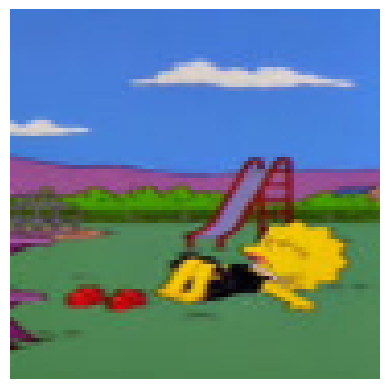

In [4]:
image_name = train_dir +"/lisa_simpson/pic_0010.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (90,90))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotLisa(image_name)

In [5]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2
                                    )

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set =  train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

val_set =  test_datagen.flow_from_directory(
                                                    val_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=False

)

Found 5722 images belonging to 5 classes.
Found 639 images belonging to 5 classes.


In [6]:
import scipy

In [6]:
for data_batch, labels_batch in training_set:
    print(data_batch.shape)
    break

(32, 90, 90, 3)


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu")) 
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

In [84]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [85]:
#checkpoint_filepath = "./simpson_model.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]

NameError: name 'checkpoint_filepath' is not defined

In [86]:
history = model.fit(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

NameError: name 'callbacks' is not defined

In [39]:
#model.save('simpson_model.keras')

In [8]:
from tensorflow.keras.models import load_model
model = load_model('simpson_model.h5')

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report


In [10]:
val_predictions = model.predict(val_set)

val_pred_labels = [np.argmax(pred) for pred in val_predictions]

val_true_labels = val_set.classes

report = classification_report(val_true_labels, val_pred_labels , target_names = labels)

print("\nClassification Report:")
print(report)


20/20 [==============================] - 3s 154ms/step

Classification Report:
                precision    recall  f1-score   support

  bart_simpson       0.96      0.84      0.90       135
 homer_simpson       0.95      0.97      0.96       225
  lisa_simpson       0.89      0.96      0.92       136
maggie_simpson       0.80      0.62      0.70        13
 marge_simpson       0.96      0.98      0.97       130

      accuracy                           0.94       639
     macro avg       0.91      0.87      0.89       639
  weighted avg       0.94      0.94      0.94       639



In [11]:
characters = ['Bart' , 'Homer' , 'Lisa' , 'Maggie' , 'Marge']

def predict(img):
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    precision = max(max(prediction))
    prediction = characters[np.argmax(prediction)]
    return prediction , precision

1/1 [==============================] - 0s 216ms/step


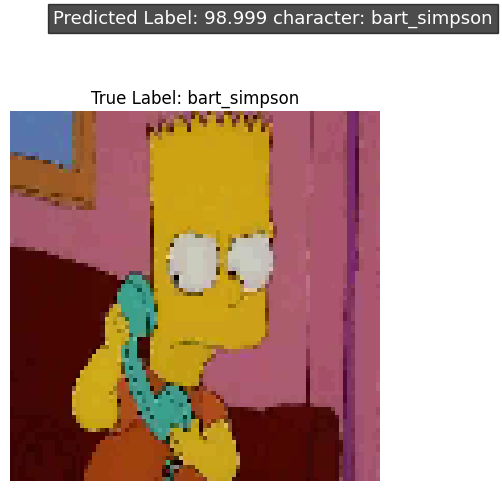

In [15]:
# Display the first image in the batch
batch_images, batch_labels = next(val_set)
first_image = batch_images[0]

# Convert from normalized form back to the original scale (if you applied rescaling during data augmentation)
first_image_original_scale = first_image * 255.0

# Display the image using matplotlib
plt.imshow(first_image_original_scale.astype('uint8'))  
plt.title(f"True Label: {labels[np.argmax(batch_labels[0])]}")

img_array = first_image
 
img_batch = np.expand_dims(img_array, axis=0)  
predictions = model.predict(img_batch)
character = labels[np.argmax(predictions)]
predicted_character = np.max(np.max(predictions))
predicted_character = round(predicted_character*100, 3)

plt.text(10, -22, f'Predicted Label: {str(predicted_character)}' + f' character: {character}' , color='white', fontsize=13, bbox=dict(facecolor='black', alpha=0.7))
plt.axis('off')
plt.show()

In [16]:
def plot_func(image_location, ax):
    imagen = cv2.imread(image_location)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    compressed_image = cv2.resize(imagen, (90,90))  / 255.0
    character , precision = predict(compressed_image)
    ax.imshow(compressed_image)
    ax.text(10, 10, f' {str(character)}' + f' Prec: {str(round(precision*100,3))}%' , color='white', bbox=dict(facecolor='black', alpha=0.7))
    ax.axis('off')
    


In [17]:
bar_1 = val_dir + "/bart_simpson/pic_1269.jpg"
bar_2 = val_dir + "/bart_simpson/pic_0035.jpg"

homer_1 = val_dir +"/homer_simpson/pic_2002.jpg"
homer_2 = val_dir + "/homer_simpson/pic_0320.jpg"

lisa_1 = val_dir + "/lisa_simpson/pic_0025.jpg"
lisa_2 = val_dir + "/lisa_simpson/pic_0035.jpg"

maggie_1 = val_dir + "/maggie_simpson/pic_0042.jpg"
maggie_2 = val_dir + "/maggie_simpson/pic_0046.jpg"

marge_1 =  val_dir + "/marge_simpson/pic_0050.jpg"
marge_2 = val_dir + "/marge_simpson/pic_0093.jpg"


1/1 [==============================] - 0s 34ms/step


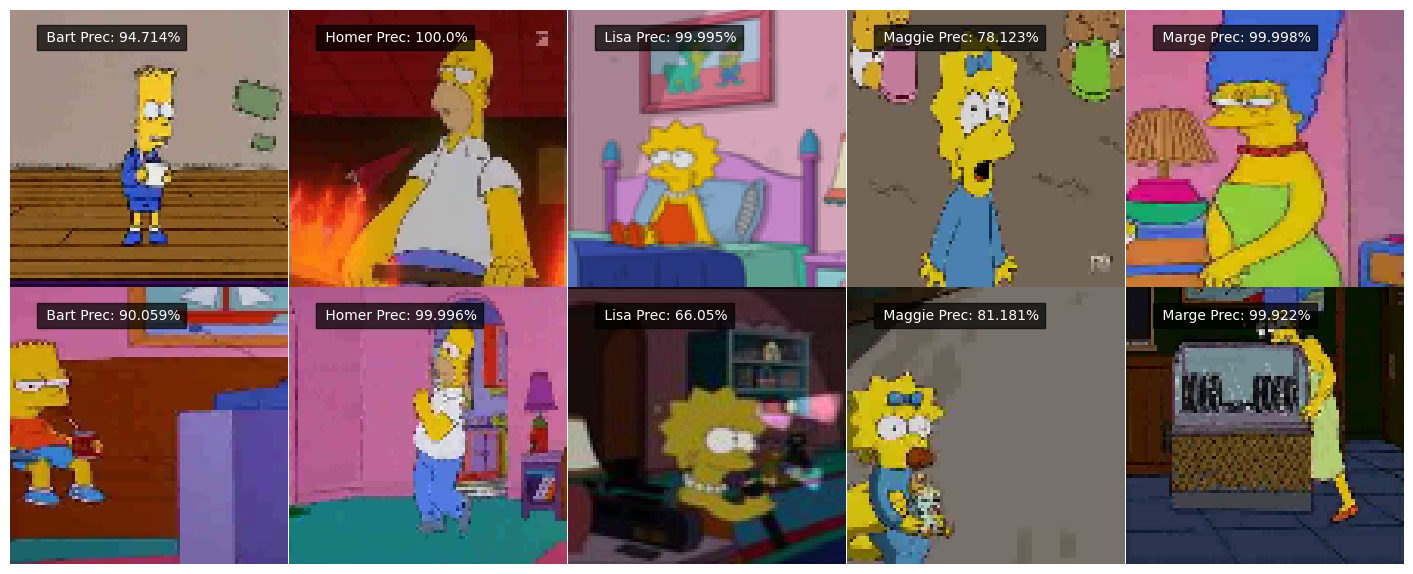

<Figure size 640x480 with 0 Axes>

In [49]:
fig, axs = plt.subplots(2, 5, figsize=(18, 7.2))
plt.subplots_adjust(wspace=0, hspace=0 )
for ax in axs.flat:
    ax.axis('off')

plot_func(bar_1 , axs[0,0])
plot_func(bar_2 , axs[1,0])

plot_func(homer_1 , axs[0,1])
plot_func(homer_2 , axs[1,1])

plot_func(lisa_1 , axs[0,2])
plot_func(lisa_2 , axs[1,2])

plot_func(maggie_1 , axs[0,3])
plot_func(maggie_2 , axs[1,3])

plot_func(marge_1 , axs[0,4])
plot_func(marge_2 , axs[1,4])

plt.show()
plt.savefig('simpson_classification.jpg')

In [43]:
def predict_all(img):
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    dict = {}
    for i in range(len(characters)):
        dict[characters[i]] = round(prediction[0][i]*100,3)
    return dict

In [44]:
def plot_func_all_characters(image_location, ax):
    imagen = cv2.imread(image_location)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    compressed_image = cv2.resize(imagen, (90,90))  / 255.0
    predictions_dict  = predict_all(compressed_image)
    predictions_dict_ord = dict(sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True))
    ax.imshow(compressed_image)
    
    text_content = '% \n'.join([f'{key}: {str(value)}' for key, value in predictions_dict_ord.items()])
    ax.text(0.35, 0.05, text_content, fontsize=10, transform=ax.transAxes, ha='right' , color = 'white' , bbox=dict(facecolor='black', alpha=0.7))
    ax.axis('off')

1/1 [==============================] - 0s 40ms/step


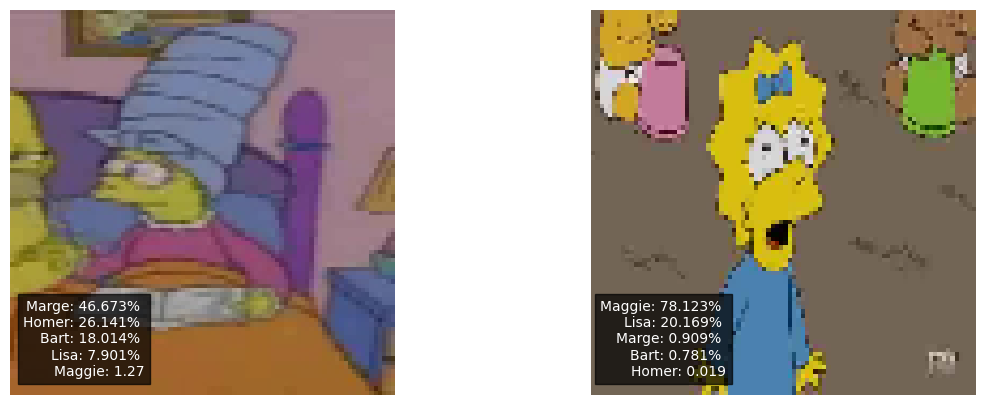

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0, hspace=0 )
marge_3 = val_dir + "/marge_simpson/pic_0136.jpg"
plot_func_all_characters(marge_3 , axs[0])
plot_func_all_characters(maggie_1 , axs[1])